## Outline:
- [Add conda environment to Jupyter Notebook](#setup)
- [Federated Learning(FL)](#intro)
- [Digit Recognition](#mnist)
- [Aggregator](#Aggregator)
    - [Aggregator Configuration](#Aggregator-Configuration)
    - [Running the Aggregator](#Running-the-Aggregator)
- [Starting Parties](#Starting-Parties)
- [Training and Evaluation](#Training-and-Evaluation)
- [Visualize Results](#Visualize-Results)
- [Shut Down](#Shut-Down)

## Federated Learning (FL) <a name="intro"></a>

**Federated Learning (FL)** is a distributed machine learning process in which each participant node (or party) retains their data locally and interacts with  other participants via a learning protocol. 
One main driver behind FL is the need to not share data with others  due to privacy and confidentially concerns.
Another driver is to improve the speed of training a machine learning model by leveraging other participants' training processes.

Setting up such a federated learning system requires setting up a communication infrastructure, converting machine learning algorithms to federated settings and in some cases knowing about the intricacies of security and privacy enabling techniques such as differential privacy and multi-party computation. 

In this Notebook, we use [IBM FL](https://github.com/IBM/federated-learning-lib) to have multiple parties train a classifier to recognise handwritten digits in the [MNIST dataset](http://yann.lecun.com/exdb/mnist/). Our focus is on a [PyTorch](https://pytorch.org/) model. 

For a more technical dive into IBM FL, refer the whitepaper [here](https://arxiv.org/pdf/2007.10987.pdf).

In the following cells, we set up each of the components of a Federated Learning network (See Figure below) wherein all involved parties aid in training their respective local cartpoles to arrive at the upright pendulum state. In this notebook we default to 5 parties, but depending on your resources you may use fewer parties.

### Getting things ready
We begin by setting the number of parties that will participate in the federated learning run and splitting up the data among them.

In [1]:
import numpy as np
import pandas as pd

In [2]:
!dir

 Volume in drive C is Windows
 Volume Serial Number is 0461-2F70

 Directory of c:\Users\willi\OneDrive\Desktop\Surrey Masters\Dissertation\aws\federated-learning-nids\data

01/09/2025  07:39 AM    <DIR>          .
01/09/2025  07:11 AM    <DIR>          ..
01/09/2025  07:53 AM    <DIR>          CIC_IDS2017
01/09/2025  09:03 PM           417,269 preprocessing.ipynb
01/09/2025  07:20 AM                 0 requirements.txt
01/09/2025  07:53 AM    <DIR>          venv
               2 File(s)        417,269 bytes
               4 Dir(s)  14,002,139,136 bytes free


In [3]:
import sys
import os

num_parties = 2  ## number of participating parties
dataset = 'cic-ids'

In [31]:
# Loading the dataset

data1 = pd.read_csv('./CIC_IDS2017/Monday-WorkingHours.pcap_ISCX.csv')
data2 = pd.read_csv('./CIC_IDS2017/Tuesday-WorkingHours.pcap_ISCX.csv')
data3 = pd.read_csv('./CIC_IDS2017/Wednesday-workingHours.pcap_ISCX.csv')
data4 = pd.read_csv('./CIC_IDS2017/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv')
data5 = pd.read_csv('./CIC_IDS2017/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv')
data6 = pd.read_csv('./CIC_IDS2017/Friday-WorkingHours-Morning.pcap_ISCX.csv')
data7 = pd.read_csv('./CIC_IDS2017/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv')
data8 = pd.read_csv('./CIC_IDS2017/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv')

In [32]:
data_list = [data1, data2, data3, data4, data5, data6, data7, data8]

print('Data dimensions: ')
for i, data in enumerate(data_list, start = 1):
  rows, cols = data.shape
  print(f'Data{i} -> {rows} rows, {cols} columns')

Data dimensions: 
Data1 -> 529918 rows, 79 columns
Data2 -> 445909 rows, 79 columns
Data3 -> 692703 rows, 79 columns
Data4 -> 170366 rows, 79 columns
Data5 -> 288602 rows, 79 columns
Data6 -> 191033 rows, 79 columns
Data7 -> 286467 rows, 79 columns
Data8 -> 225745 rows, 79 columns


In [33]:
data = pd.concat(data_list)
rows, cols = data.shape

print('New dimension:')
print(f'Number of rows: {rows}')
print(f'Number of columns: {cols}')
print(f'Total cells: {rows * cols}')

New dimension:
Number of rows: 2830743
Number of columns: 79
Total cells: 223628697


In [34]:
data

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,49188,4,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,49188,1,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,49188,1,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,49188,1,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,49486,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225740,61374,61,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
225741,61378,72,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
225742,61375,75,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
225743,61323,48,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [35]:
# Deleting dataframes after concating to save memory
for d in data_list: del d

# Renaming the columns by removing leading/trailing whitespace
col_names = {col: col.strip() for col in data.columns}
data.rename(columns = col_names, inplace = True)

data.columns

Index(['Destination Port', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Total Length of Fwd Packets',
       'Total Length of Bwd Packets', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Min Packet Length', 'Max Packet Length', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count',
       'SYN Flag Co

In [36]:
pd.options.display.max_rows = 80

print('Overview of Columns:')
data.describe().transpose()

Overview of Columns:


c:\Users\willi\OneDrive\Desktop\Surrey Masters\Dissertation\aws\p2p-federated-nids\venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\willi\OneDrive\Desktop\Surrey Masters\Dissertation\aws\p2p-federated-nids\venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,count,mean,std,min,25%,50%,75%,max
Destination Port,2830743.0,8.071483e+03,1.828363e+04,0.000000e+00,53.000000,80.000000,4.430000e+02,6.553500e+04
Flow Duration,2830743.0,1.478566e+07,3.365374e+07,-1.300000e+01,155.000000,31316.000000,3.204828e+06,1.200000e+08
Total Fwd Packets,2830743.0,9.361160e+00,7.496728e+02,1.000000e+00,2.000000,2.000000,5.000000e+00,2.197590e+05
Total Backward Packets,2830743.0,1.039377e+01,9.973883e+02,0.000000e+00,1.000000,2.000000,4.000000e+00,2.919220e+05
Total Length of Fwd Packets,2830743.0,5.493024e+02,9.993589e+03,0.000000e+00,12.000000,62.000000,1.870000e+02,1.290000e+07
Total Length of Bwd Packets,2830743.0,1.616264e+04,2.263088e+06,0.000000e+00,0.000000,123.000000,4.820000e+02,6.554530e+08
Fwd Packet Length Max,2830743.0,2.075999e+02,7.171848e+02,0.000000e+00,6.000000,37.000000,8.100000e+01,2.482000e+04
Fwd Packet Length Min,2830743.0,1.871366e+01,6.033935e+01,0.000000e+00,0.000000,2.000000,3.600000e+01,2.325000e+03
Fwd Packet Length Mean,2830743.0,5.820194e+01,1.860912e+02,0.000000e+00,6.000000,34.000000,5.000000e+01,5.940857e+03
Fwd Packet Length Std,2830743.0,6.891013e+01,2.811871e+02,0.000000e+00,0.000000,0.000000,2.616295e+01,7.125597e+03


In [37]:
# Replacing any infinite values (positive or negative) with NaN (not a number)
print(f'Initial missing values: {data.isna().sum().sum()}')

data.replace([np.inf, -np.inf], 0, inplace = True)

print(f'Missing values after processing infinite values: {data.isna().sum().sum()}')

Initial missing values: 1358
Missing values after processing infinite values: 1358


In [38]:
missing = data.isna().sum()
print(missing.loc[missing > 0])

Flow Bytes/s    1358
dtype: int64


In [39]:
med_flow_bytes = data['Flow Bytes/s'].median()
med_flow_packets = data['Flow Packets/s'].median()

print('Median of Flow Bytes/s: ', med_flow_bytes)
print('Median of Flow Packets/s: ', med_flow_packets)

Median of Flow Bytes/s:  4577.33171
Median of Flow Packets/s:  108.2163244


In [40]:
# Filling missing values with median
data['Flow Bytes/s'].fillna(med_flow_bytes, inplace = True)
data['Flow Packets/s'].fillna(med_flow_packets, inplace = True)

C:\Users\willi\AppData\Local\Temp\ipykernel_3324\1818654804.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Flow Bytes/s'].fillna(med_flow_bytes, inplace = True)
C:\Users\willi\AppData\Local\Temp\ipykernel_3324\1818654804.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

In [41]:
# Creating a dictionary that maps each label to its attack type
attack_map = {
    'BENIGN': 'BENIGN',
    'DDoS': 'DDoS',
    'DoS Hulk': 'DoS',
    'DoS GoldenEye': 'DoS',
    'DoS slowloris': 'DoS',
    'DoS Slowhttptest': 'DoS',
    'PortScan': 'Port Scan',
    'FTP-Patator': 'Brute Force',
    'SSH-Patator': 'Brute Force',
    'Bot': 'Bot',
    'Web Attack � Brute Force': 'Web Attack',
    'Web Attack � XSS': 'Web Attack',
    'Web Attack � Sql Injection': 'Web Attack',
    'Infiltration': 'Infiltration',
    'Heartbleed': 'Heartbleed'
}

# Creating a new column 'Attack Type' in the DataFrame based on the attack_map dictionary
data['Attack Type'] = data['Label'].map(attack_map)

In [42]:
data['Attack Type'].unique()

array(['BENIGN', 'Brute Force', 'DoS', 'Heartbleed', 'Web Attack',
       'Infiltration', 'Bot', 'Port Scan', 'DDoS'], dtype=object)

In [43]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data['label'] = le.fit_transform(data['Attack Type'])

print(data['label'].unique())

[0 2 4 5 8 6 1 7 3]


In [44]:
data.drop('Label', axis = 1, inplace = True)

In [45]:
# Printing corresponding attack type for each encoded value
encoded_values = data['label'].unique()
for val in sorted(encoded_values):
    print(f"{val}: {le.inverse_transform([val])[0]}")

0: BENIGN
1: Bot
2: Brute Force
3: DDoS
4: DoS
5: Heartbleed
6: Infiltration
7: Port Scan
8: Web Attack


In [46]:
data['label'].unique()

array([0, 2, 4, 5, 8, 6, 1, 7, 3])

In [47]:
data['Flow Bytes/s'].fillna(0, inplace = True)
missing = data.isna().sum()
print(missing.loc[missing > 0])

C:\Users\willi\AppData\Local\Temp\ipykernel_3324\2021040566.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Flow Bytes/s'].fillna(0, inplace = True)


Series([], dtype: int64)


In [48]:
data.drop('Attack Type', axis = 1, inplace = True)

In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split


# Separate features and target
X = data.drop(columns=["label"])
y = data["label"]

# Split into train and test sets (optional but good practice)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Train a Random Forest Classifier
rf = RandomForestClassifier(
    n_estimators=200,       # more trees for stability
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

# Get feature importances
importances = rf.feature_importances_

# Create a DataFrame for better readability
feature_importances = pd.DataFrame({
    "Feature": X.columns,
    "Importance": importances
})

# Sort features by importance (ascending)
feature_importances = feature_importances.sort_values(by="Importance", ascending=True)

# Select the 20 least important features
least_important_20 = feature_importances.head(20)

print("20 Least Important Features (Ranked):")
print(least_important_20)


20 Least Important Features (Ranked):
                 Feature    Importance
31         Bwd PSH Flags  0.000000e+00
33         Bwd URG Flags  0.000000e+00
61     Bwd Avg Bulk Rate  0.000000e+00
60  Bwd Avg Packets/Bulk  0.000000e+00
59    Bwd Avg Bytes/Bulk  0.000000e+00
56    Fwd Avg Bytes/Bulk  0.000000e+00
58     Fwd Avg Bulk Rate  0.000000e+00
57  Fwd Avg Packets/Bulk  0.000000e+00
45        RST Flag Count  5.165081e-08
50        ECE Flag Count  7.519426e-08
32         Fwd URG Flags  1.014811e-05
49        CWE Flag Count  1.258924e-05
75              Idle Std  4.373826e-04
44        SYN Flag Count  4.431133e-04
30         Fwd PSH Flags  4.630371e-04
71            Active Std  5.828788e-04
51         Down/Up Ratio  6.450653e-04
73            Active Min  9.320608e-04
27           Bwd IAT Std  1.052818e-03
43        FIN Flag Count  1.079455e-03


C:\Users\willi\AppData\Local\Temp\ipykernel_3324\3922833234.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


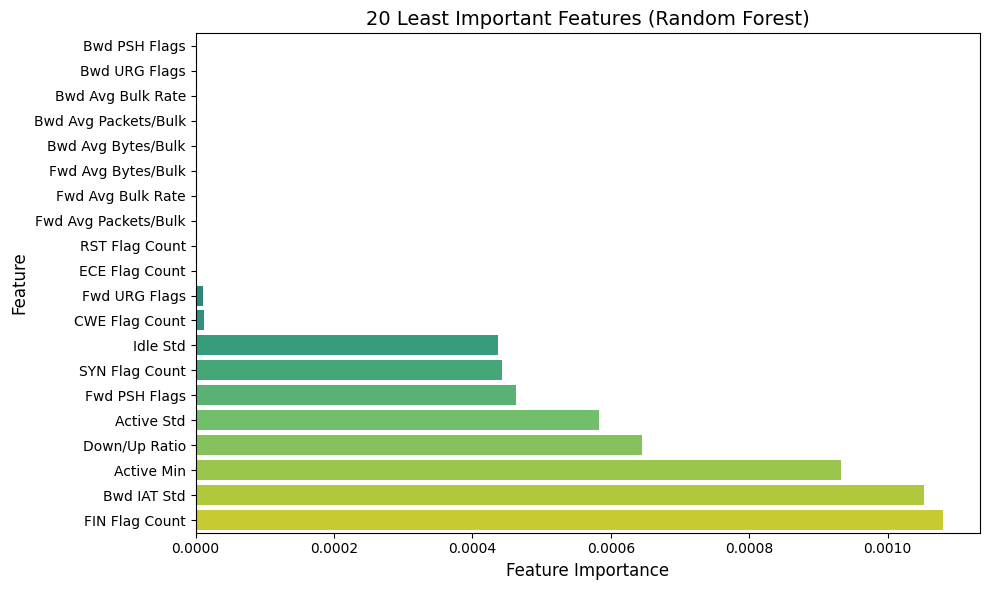

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the 20 least important features
plt.figure(figsize=(10, 6))
sns.barplot(
    x="Importance",
    y="Feature",
    data=least_important_20,
    palette="viridis"
)

plt.title("20 Least Important Features (Random Forest)", fontsize=14)
plt.xlabel("Feature Importance", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.tight_layout()
plt.show()


C:\Users\willi\AppData\Local\Temp\ipykernel_3324\3915748367.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


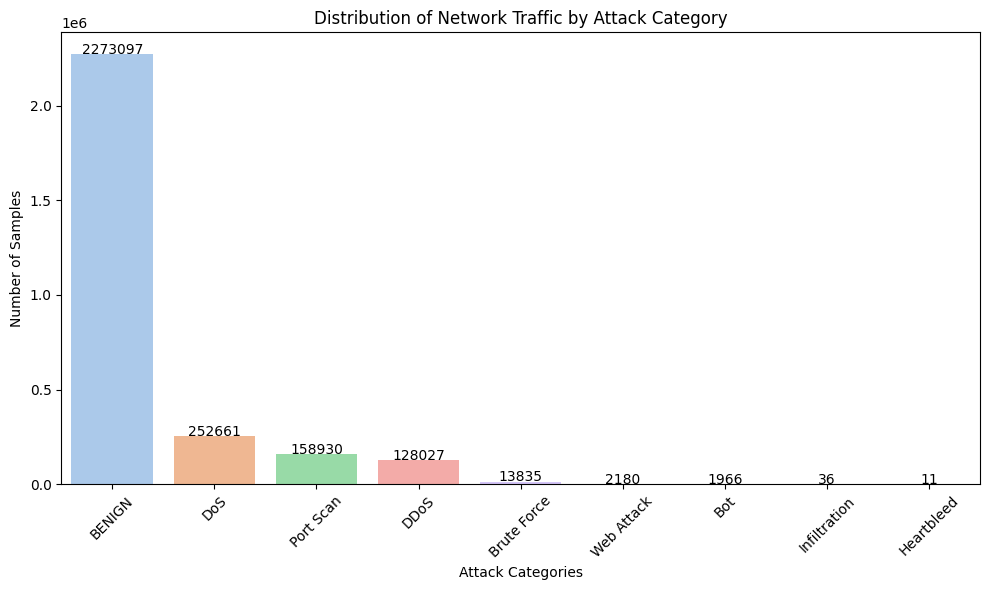

In [51]:
# Mapping dictionary
label_map = {
    0: "BENIGN",
    1: "Bot",
    2: "Brute Force",
    3: "DDoS",
    4: "DoS",
    5: "Heartbleed",
    6: "Infiltration",
    7: "Port Scan",
    8: "Web Attack"
}

# Replace numeric labels with names
data["label_name"] = data["label"].map(label_map)

plt.figure(figsize=(10, 6))
ax = sns.countplot(
    x="label_name",
    data=data,
    palette="pastel",
    order=data["label_name"].value_counts().index
)

plt.title("Distribution of Network Traffic by Attack Category")
plt.xlabel("Attack Categories")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45)

# Annotate bars with counts
for p in ax.patches:
    ax.annotate(
        f'{p.get_height():.0f}',
        (p.get_x() + p.get_width() / 2, p.get_height() + 1000),
        ha='center'
    )

# Add a legend if you want to keep color reference
# plt.legend(title="Attack Type", loc="upper right")
plt.tight_layout()
plt.show()


In [52]:
data['label'].value_counts()

label
0    2273097
4     252661
7     158930
3     128027
2      13835
8       2180
1       1966
6         36
5         11
Name: count, dtype: int64

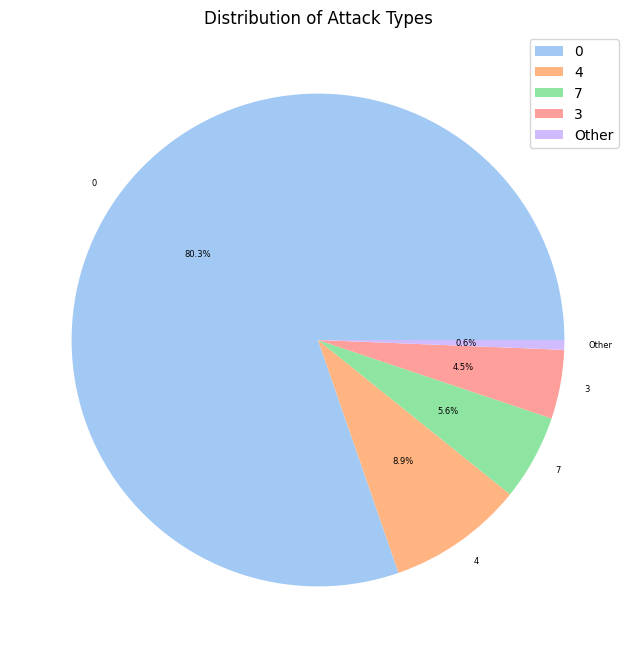

In [53]:
attack_counts = data['label'].value_counts()
threshold = 0.005
percentages = attack_counts / attack_counts.sum()
small_slices = percentages[percentages < threshold].index.tolist()
attack_counts['Other'] = attack_counts[small_slices].sum()
attack_counts.drop(small_slices, inplace = True)

sns.set_palette('pastel')
plt.figure(figsize = (8, 8))
plt.pie(attack_counts.values, labels = attack_counts.index, autopct = '%1.1f%%', textprops={'fontsize': 6})
plt.title('Distribution of Attack Types')
plt.legend(attack_counts.index, loc = 'best')
plt.show()

In [54]:
class_counts = data['label'].value_counts()
selected_classes = class_counts[class_counts > 1950]
class_names = selected_classes.index
selected = data[data['label'].isin(class_names)]

dfs = []
for name in class_names:
  df = selected[selected['label'] == name]
  if len(df) > 2500:
    df = df.sample(n = 10000, random_state = 0)

  dfs.append(df)

df = pd.concat(dfs, ignore_index = True)
df['label'].value_counts()

label
0    10000
4    10000
7    10000
3    10000
2    10000
8     2180
1     1966
Name: count, dtype: int64

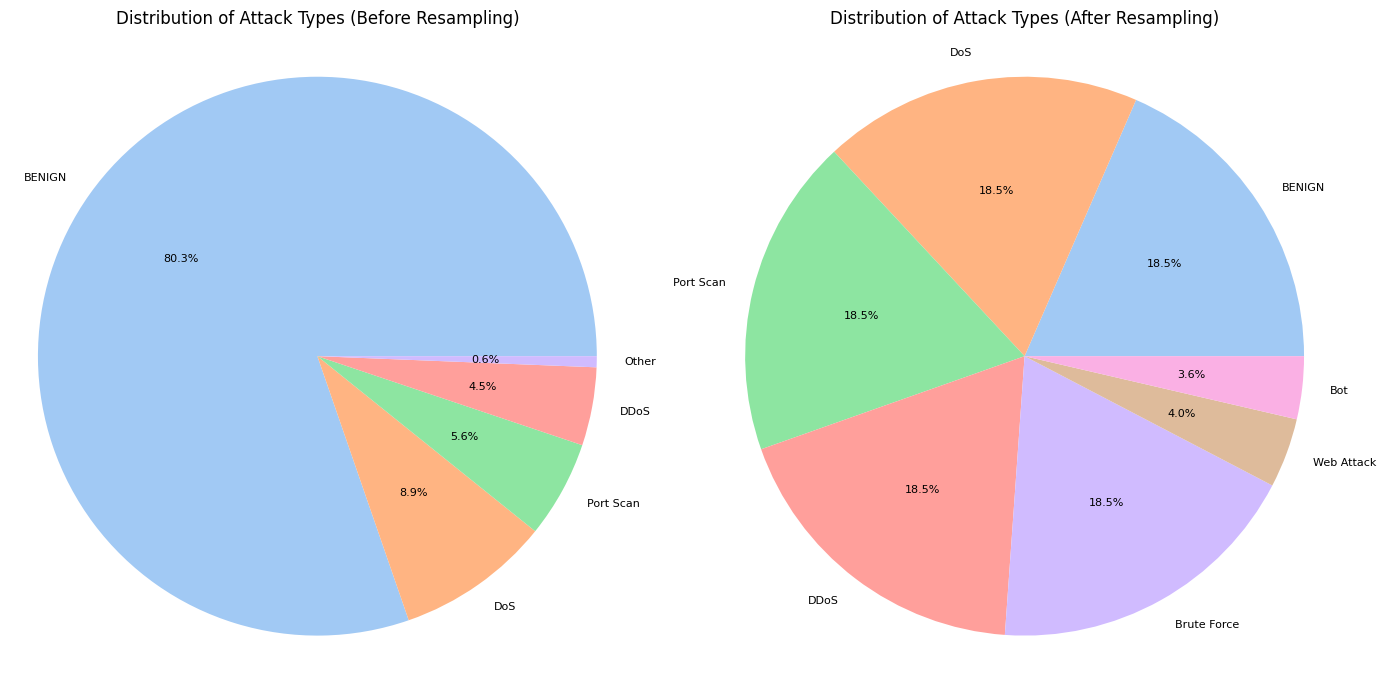

In [55]:
# 1) Map numeric labels to names
label_map = {
    0: "BENIGN",
    1: "Bot",
    2: "Brute Force",
    3: "DDoS",
    4: "DoS",
    5: "Heartbleed",
    6: "Infiltration",
    7: "Port Scan",
    8: "Web Attack"
}

def grouped_counts(frame, label_col="label", label_map=None, threshold=0.005):
    """Return counts with small categories merged into 'Other'."""
    counts = frame[label_col].value_counts()

    # Map numeric codes to names (leave as-is if already strings/unmapped)
    if label_map is not None:
        counts.index = counts.index.map(lambda x: label_map.get(x, x))

    # Group small slices
    percentages = counts / counts.sum()
    small = percentages[percentages < threshold].index
    counts_grouped = counts.copy()
    if len(small) > 0:
        counts_grouped.loc["Other"] = counts_grouped.loc[small].sum()
        counts_grouped = counts_grouped.drop(index=small)

    # Sort for consistent legend order
    return counts_grouped.sort_values(ascending=False)

# === params ===
threshold = 0.005  # 0.5% cutoff for "Other"

# 2) compute grouped counts for both dataframes
before_counts = grouped_counts(data, label_col="label", label_map=label_map, threshold=threshold)
after_counts  = grouped_counts(df,   label_col="label", label_map=label_map, threshold=threshold)

# 3) plot side-by-side
sns.set_palette("pastel")
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

axes[0].pie(before_counts.values,
            labels=before_counts.index,
            autopct="%1.1f%%",
            textprops={"fontsize":8})
axes[0].set_title("Distribution of Attack Types (Before Resampling)")
axes[0].axis("equal")

axes[1].pie(after_counts.values,
            labels=after_counts.index,
            autopct="%1.1f%%",
            textprops={"fontsize":8})
axes[1].set_title("Distribution of Attack Types (After Resampling)")
axes[1].axis("equal")

plt.tight_layout()
plt.show()


In [ ]:
if exclusive_map is None:
        exclusive_map = {"Region1": "Heart Bleed", "Region2": "DoS", "Region3": "Web Attack"}

    regions = list(exclusive_map.keys())
    if len(regions) != 3:
        raise ValueError("This function expects exactly 3 regions in exclusive_map.")

    df = df.copy()

    # Optionally collapse labels to coarse categories
    if coarse_label_map is not None:
        df[label_col] = df[label_col].map(lambda x: coarse_label_map.get(x, x))

    # Basic validation
    missing = [cat for cat in exclusive_map.values() if cat not in set(df[label_col].unique())]
    if missing:
        raise ValueError(
            f"The following exclusive categories are not present in '{label_col}': {missing}"
        )

    rng = np.random.RandomState(random_state)

    # 1) Shuffle
    df = df.sample(frac=1.0, random_state=random_state).reset_index(drop=True)

    # 2) Remove exclusive categories globally
    exclusive_cats = set(exclusive_map.values())
    df_exclusive = df[df[label_col].isin(exclusive_cats)]
    df_remaining = df[~df[label_col].isin(exclusive_cats)]

    # Keep per-category exclusive slices so we can add them to the right region later
    exclusive_slices = {cat: df_exclusive[df_exclusive[label_col] == cat] for cat in exclusive_cats}

    # 3) Stratify-split remaining data equally across 3 regions
    region_parts = {r: [] for r in regions}
    for cat, grp in df_remaining.groupby(label_col, sort=False):
        grp = grp.sample(frac=1.0, random_state=rng.randint(0, 10_000_000))
        splits = np.array_split(grp, 3)  # sizes differ by at most 1
        for r, part in zip(regions, splits):
            if not part.empty:
                region_parts[r].append(part)

    region_dfs = {r: (pd.concat(parts, ignore_index=True) if parts else pd.DataFrame(columns=df.columns))
                  for r, parts in region_parts.items()}

    # 4) Add back exclusive categories to designated regions ONLY
    for r, cat in exclusive_map.items():
        add_df = exclusive_slices[cat]
        # Concatenate and reshuffle for good measure
        region_dfs[r] = pd.concat([region_dfs[r], add_df], ignore_index=True)
        region_dfs[r] = region_dfs[r].sample(frac=1.0, random_state=rng.randint(0, 10_000_000)).reset_index(drop=True)

    # # 5) Save CSVs
    # out = Path(output_dir)
    # out.mkdir(parents=True, exist_ok=True)
    # file_map = {}
    # for r, df_part in region_dfs.items():
    #     fname = out / f"{r}.csv"
    #     df_part.to_csv(fname, index=False)
    #     file_map[r] = str(fname)

    # # Print a compact summary
    # def counts(df_part: pd.DataFrame) -> pd.Series:
    #     return df_part[label_col].value_counts().sort_index()

    # summary = pd.DataFrame({r: counts(df_part) for r, df_part in region_dfs.items()}).fillna(0).astype(int)
    # print("\n=== Partition Summary (rows per category) ===")
    # print(summary)
    # print("\nExclusive category per region:", exclusive_map)
    # print("\nSaved files:")
    # for r, path in file_map.items():
    #     print(f"  {r}: {path}")

In [27]:
# Check for NaNs
print("NaNs in :", data.isnull().sum())

# Check for infinite values
print("Infinite in X:", np.isinf(data).sum().sum())

NaNs in : Destination Port               0
Flow Duration                  0
Total Fwd Packets              0
Total Backward Packets         0
Total Length of Fwd Packets    0
Total Length of Bwd Packets    0
Fwd Packet Length Max          0
Fwd Packet Length Min          0
Fwd Packet Length Mean         0
Fwd Packet Length Std          0
Bwd Packet Length Max          0
Bwd Packet Length Min          0
Bwd Packet Length Mean         0
Bwd Packet Length Std          0
Flow Bytes/s                   0
Flow Packets/s                 0
Flow IAT Mean                  0
Flow IAT Std                   0
Flow IAT Max                   0
Flow IAT Min                   0
Fwd IAT Total                  0
Fwd IAT Mean                   0
Fwd IAT Std                    0
Fwd IAT Max                    0
Fwd IAT Min                    0
Bwd IAT Total                  0
Bwd IAT Mean                   0
Bwd IAT Std                    0
Bwd IAT Max                    0
Bwd IAT Min                    0


In [28]:
from imblearn.over_sampling import SMOTE

X = data.drop('label', axis=1)
y = data['label']

smote = SMOTE(sampling_strategy='auto', random_state=0)
X_upsampled, y_upsampled = smote.fit_resample(X, y)

blnc_data = pd.DataFrame(X_upsampled)
blnc_data['label'] = y_upsampled
blnc_data = blnc_data.sample(frac=1)

blnc_data['label'].value_counts()

5    193748
4    193748
1    193748
7    193748
2    193748
3    193748
0    193748
6    193748
Name: label, dtype: int64

In [29]:
data.columns

Index(['Destination Port', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Total Length of Fwd Packets',
       'Total Length of Bwd Packets', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Min Packet Length', 'Max Packet Length', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count',
       'SYN Flag Co

In [30]:
data

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,label
0,80,5216127,3,1,0,0,0,0,0.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,1
1,21,20,1,1,0,0,0,0,0.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,1
2,21,38,1,1,0,0,0,0,0.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,1
3,21,80,1,1,0,0,0,0,0.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,1
4,21,68,1,1,0,0,0,0,0.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
425873,80,163071,4,0,24,0,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,2
425874,80,2036,3,6,26,11607,20,0,8.666667,10.263203,...,20,0.0,0.0,0,0,0.0,0.0,0,0,2
425875,80,159465,4,0,24,0,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,2
425876,80,1453,3,6,26,11607,20,0,8.666667,10.263203,...,20,0.0,0.0,0,0,0.0,0.0,0,0,2


In [31]:
import sys
print(sys.version)


3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 05:35:01) [MSC v.1916 64 bit (AMD64)]


In [32]:
data.to_csv('examples/datasets/cic-ids.csv', index=False)

We use `examples/generate_data.py` to split the dataset into files for each party. 

The script allows specifying the number of parties as well as the dataset to use (from several supported datasets: _mnist_, _femnist_, _cifar10_ and many others). 

The `-pp` argument states how many data points to choose per party. If the option `--stratify` is given, the library stratifies the data proportionally according to the source distribution. If you want to run this notebook in different machines, you can assign samples for each party locally. Then, we define the neural network definition.

In [33]:
%run  examples/generate_data.py -n $num_parties -d $dataset -pp 200 

📂 Loading dataset from: examples\datasets\cic-ids.csv
✅ Saved party 0 data to: examples\data\cic-ids\random\data_party0.csv
✅ Saved party 1 data to: examples\data\cic-ids\random\data_party1.csv
🎉 Finished! All party data saved in: examples\data\cic-ids\random


Generate the PyTorch model definition file using the function `save_model_config` below. Please note that parties data and the model file needs to be copied to the parties if you launch parties on different nodes.

In [34]:
input_dim = len(data.columns.unique()) - 1
num_classes = len(data['label'].unique())
(input_dim, num_classes)

(78, 8)

In [35]:
import os
import torch
from torch import nn

def save_model_config(folder_configs):
    model = nn.Sequential( 
        nn.Linear(input_dim, 128),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(64, num_classes),
        nn.LogSoftmax(dim=1)
        )
    if not os.path.exists(folder_configs):
        os.makedirs(folder_configs)

    # Save model
    fname = os.path.join(folder_configs, 'pytorch_sequence.pt')
    torch.save(model, fname)
    # Specify an optimizer class as optim.<optimizer> 
    # The entire expression should be of type string
    # e.g., optimizer = 'optim.SGD'
    optimizer = 'optim.Adam'
    # Specify a loss criterion as nn.<loss-criterion>
    # The entire expression should be of type string
    # e.g., criterion = 'nn.NLLLoss'
    criterion = 'nn.NLLLoss'
    spec = {
        'model_name': 'pytorch-nn',
        'model_definition': fname,
        'optimizer': optimizer,
        'loss_criterion': criterion,
    }
    model = {
        'name': 'PytorchFLModel',
        'path': 'ibmfl.model.pytorch_fl_model',
        'spec': spec,
    }
    return model
save_model_config('examples/configs/pytorch_classifier')

c:\Users\willi\OneDrive\Desktop\Surrey Masters\Dissertation\IBM-federated-learning-lib\myvenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{'name': 'PytorchFLModel',
 'path': 'ibmfl.model.pytorch_fl_model',
 'spec': {'model_name': 'pytorch-nn',
  'model_definition': 'examples/configs/pytorch_classifier\\pytorch_sequence.pt',
  'optimizer': 'optim.Adam',
  'loss_criterion': 'nn.NLLLoss'}}

## Aggregator

coordinates the overall process, communicates with the parties and integrates the results of the training process. This integration of results is done using the _Fusion Algorithm_.

A fusion algorithm queries the registered parties to carry out the federated learning process. The queries sent vary according to the model/algorithm type.  In return, parties send their reply as a model update object, and these model updates are then aggregated according to the specified Fusion Algorithm, specified via a `Fusion Handler` class. 

To take a look at the supported fusion algorithms, refer the IBM FL tutorial page [here](https://github.com/IBM/federated-learning-lib/blob/main/README.md#supported-functionality).

### Aggregator Configuration

We discuss the various configuration parameters for the Aggregator [here.](https://github.com/IBM/federated-learning-lib/blob/main/docs/tutorials/configure_fl.md#the-aggregators-configuration-file)

Given below is an example of the aggregator's configuration file. In this example, the aggregator does not specify a data file or maintain a global model. Hence, during the federated learning process, it only keeps track of the current model parameters. 

However, it is possible that the aggregator also has data for testing purposes and maintains a global model. When this is the case, one needs to add `data` and `model` sections in the configuration file.

<img style="display=block; margin:auto" src="../images/arch_aggregator.png" width="680"/>
<p style="text-align: center">Image Source: <a href="https://arxiv.org/pdf/2007.10987.pdf">IBM Federated Learning: An Enterprise FrameworkWhite Paper V0.1</a></p>

#### Building blocks in the configuration file:

- `connection` (also used in Party config): needed to initiate the connection; includes server information (`info`, optional, depends on the connection type), a connection class name, a connection file location, and a synchronization mode flag (`sync`) for training phase

- `fusion`: needed to initiate a fusion algorithm at the aggregator side; includes a fusion handler class name and a fusion handler file location

- `protocol_handler`: needed to initiate a protocol; includes a protocol handler class name and a protocol handler file location

- `hyperparams`: includes global training and local training hyperparameters, including `termination_accuracy`, learning rate (`lr`), `optimizer`, etc., depending on the model being used.

For detailed documentation of the objects described below, refer the API docs [here](https://ibmfl.mybluemix.net/api-documentation).

In [36]:
agg_config = {
    'connection': {
        'info': {
            'ip': '127.0.0.1',
            'port': 5000,
            'tls_config': {
                'enable': 'false'
            }
        },
        'name': 'FlaskConnection',
        'path': 'ibmfl.connection.flask_connection',
        'sync': 'False'
    },
    'data': {
        'info': {
            'data_file': 'examples/datasets/cic-ids.csv'
        },
        'name': 'CicIdsDataHandler',
        'path': 'ibmfl.util.data_handlers.cicids_data_handler'
    },
    'fusion': {
        'name': 'IterAvgFusionHandler',
        'path': 'ibmfl.aggregator.fusion.iter_avg_fusion_handler'
    },
    'hyperparams': {
        'global': {
            'max_timeout': 60,
            'num_parties': num_parties,
            'perc_quorum': 1,
            'rounds': 12,
            'termination_accuracy': 0.9
        },
        'local': {
            'training': {
                'epochs': 3,
                'lr': 0.01
            }
        }
    },
    'protocol_handler': {
        'name': 'ProtoHandler',
        'path': 'ibmfl.aggregator.protohandler.proto_handler'
    }
}

### Running the Aggregator
Next we pass the configuration parameters set in the previous cell to instantiate the `Aggregator` object. Finally, we `start()` the Aggregator process.

In [37]:

from ibmfl.aggregator.aggregator import Aggregator
aggregator = Aggregator(config_dict=agg_config)

aggregator.start()

2025-08-15 09:29:26,719 | 2.0.1 | INFO | ibmfl.util.config                             | Getting Aggregator details from arguments.
2025-08-15 09:29:26,726 | 2.0.1 | INFO | ibmfl.util.config                             | No metrics recorder config provided for this setup.
2025-08-15 09:29:26,727 | 2.0.1 | INFO | ibmfl.util.config                             | No model config provided for this setup.
2025-08-15 09:29:27,023 | 2.0.1 | INFO | ibmfl.util.config                             | No metrics config provided for this setup.
2025-08-15 09:29:27,025 | 2.0.1 | INFO | ibmfl.util.config                             | No evidencia recordeer config provided for this setup.
2025-08-15 09:29:27,027 | 2.0.1 | INFO | ibmfl.util.data_handlers.cicids_data_handler  | Loading CIC IDS dataset from: examples/datasets/cic-ids.csv
2025-08-15 09:29:30,232 | 2.0.1 | INFO | ibmfl.connection.flask_connection             | RestSender initialized
2025-08-15 09:29:30,234 | 2.0.1 | INFO | ibmfl.aggregator.pr

<img style="display=block; margin:auto" src="../images/arch_party.png" width="680"/>
<p style="text-align: center">Image Source: <a href="https://arxiv.org/pdf/2007.10987.pdf">IBM Federated Learning: An Enterprise FrameworkWhite Paper V0.1</a></p>

## Starting Parties

Now that we have Aggregator running, next we go to Parties' notebooks (`pytorch_classifier_p0.ipynb` and `pytorch_classifier_p1.ipynb`) to start and register them with the Aggregator. Once all the parties are done with registration, we will move to next step to start training.

## Training and Evaluation

Now that our network has been set up, we begin training the model by invoking the Aggregator's `start_training()` method. 

This could take some time, depending on your system specifications. Feel free to get your dose of coffee meanwhile ☕

In [38]:
"""
#1 Initialize the metrics collector variables
"""
num_parties = agg_config['hyperparams']['global']['num_parties']
eval_party_accuracy = [[] for _ in range(num_parties)]
iterations = [[] for _ in range(num_parties)]

"""
#2 Register handler for metrics collector
"""
def get_metrics(metrics):
    keys = list(metrics['party'].keys())
    keys.sort()
    for i in range(len(keys)):
      eval_party_accuracy[i].append(metrics['party'][keys[i]]['accuracy_score'])
      iterations[i].append(metrics['fusion']['curr_round']*agg_config['hyperparams']['local']['training']['epochs'])
      
mh = aggregator.fusion.metrics_manager
mh.register(get_metrics)


"""
#3 start the training
"""
aggregator.start_training()

2025-08-15 09:29:30,258 | 2.0.1 | INFO | ibmfl.aggregator.aggregator                   | Initiating Global Training.
2025-08-15 09:29:30,259 | 2.0.1 | INFO | ibmfl.aggregator.fusion.fusion_handler        | Warm start disabled.
2025-08-15 09:29:30,260 | 2.0.1 | INFO | ibmfl.aggregator.fusion.iter_avg_fusion_handler | Model updateNone
2025-08-15 09:29:30,261 | 2.0.1 | ERROR | ibmfl.aggregator.aggregator                   | Exception occurred while training.
Traceback (most recent call last):
  File "c:\Users\willi\OneDrive\Desktop\Surrey Masters\Dissertation\IBM-federated-learning-lib\myvenv\lib\site-packages\ibmfl\aggregator\aggregator.py", line 203, in start_training
    self.fusion.start_global_training()
  File "c:\Users\willi\OneDrive\Desktop\Surrey Masters\Dissertation\IBM-federated-learning-lib\myvenv\lib\site-packages\ibmfl\aggregator\fusion\iter_avg_fusion_handler.py", line 98, in start_global_training
    lst_replies = self.query_all_parties(payload)
  File "c:\Users\willi\OneD

False

### Plot accuracy versus epochs

ValueError: min() arg is an empty sequence

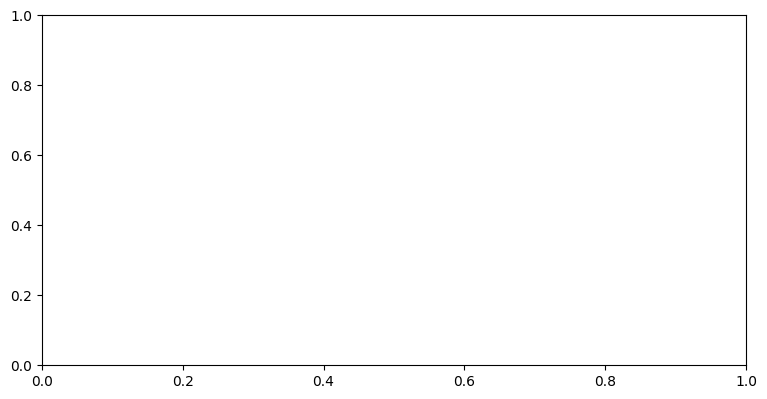

In [39]:
"""
#1 define a method to plot a smooth cure
"""
from matplotlib import pyplot as plt
from scipy.interpolate import make_interp_spline, BSpline
import numpy as np

def smooth_curve(xaxis, yaxis):
   xnew = np.linspace(min(xaxis), max(xaxis), len(xaxis)*50) 

   spl = make_interp_spline(xaxis, yaxis, k=1)  # type: BSpline
   power_smooth = spl(xnew)
   return xnew, power_smooth 

f = plt.figure(figsize=(20,10))
plt.subplot(2, 2, 1)

num_parties = agg_config['hyperparams']['global']['num_parties']


"""
#2 plot the evaluation curve
"""
for i in range(num_parties):
    eval_party_xaxis, eval_party_yaxis = smooth_curve(iterations[i], eval_party_accuracy[i])
    line1, = plt.plot(eval_party_xaxis, eval_party_yaxis)
    line1.set_label('party'+str(i+1))
plt.title('Evaluation Plot')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

## Shut Down

Invoke the `stop()` method on each of the network participants to terminate the service.

In [ ]:
aggregator.stop()

2025-07-31 07:08:22,057 | 2.0.1 | INFO | ibmfl.aggregator.protohandler.proto_handler   | State: States.SND_REQ
2025-07-31 07:08:22,168 | 2.0.1 | INFO | ibmfl.aggregator.protohandler.proto_handler   | Total number of success responses :2
2025-07-31 07:08:22,169 | 2.0.1 | INFO | ibmfl.aggregator.protohandler.proto_handler   | Number of parties queried:2
2025-07-31 07:08:22,171 | 2.0.1 | INFO | ibmfl.aggregator.protohandler.proto_handler   | Number of registered parties:2
2025-07-31 07:08:22,172 | 2.0.1 | INFO | ibmfl.connection.flask_connection             | Stopping Receiver and Sender
2025-07-31 07:08:22,185 | 2.0.1 | INFO | werkzeug                                      | 127.0.0.1 - - [31/Jul/2025 07:08:22] "POST /shutdown HTTP/1.1" 200 -
2025-07-31 07:08:22,187 | 2.0.1 | INFO | ibmfl.aggregator.aggregator                   | Aggregator stop successful


c:\Users\willi\OneDrive\Desktop\Surrey Masters\Dissertation\IBM-federated-learning-lib\myvenv\lib\site-packages\ibmfl\connection\flask_connection.py:240: UserWarning: The 'environ['werkzeug.server.shutdown']' function is deprecated and will be removed in Werkzeug 2.1.
  func()


## Visualize Parties' Training
Please go to Parties' notebooks to visalize summary of Parties' training.